# Práctica 2 - Ejercicio 2

Asignatura: Programación para la Inteligencia Artificial

Alumno:- Laura Mondéjar Ruiz

Este es el segundo ejercicio de la Práctica 2 de Programación para la Inteligencia Artificial. Este ejercicio se debe entregar en un cuaderno de Jupyter separado del primero.

CIFAR100 es un conjunto de datos con dos niveles de etiquetado. Un etiquetado *fino* con 100 clases y un etiquetado *grueso* con 20 superclases. Se desea un sistema basado en neuronas lineales que tenga capacidad para realizar el etiquetado *fino*, pero se propone estudiar si la información que da el etiquetado *grueso* puede ayudar en la tarea aprovechando la probabilidad condicionada:

$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Se espera una comparación entre la aproximación que usa solo un modelo neuronal para el etiquetado *fino* y la aproximación que incluye información del etiquetado *grueso*.

Información del conjunto de datos:

https://www.cs.toronto.edu/~kriz/cifar.html

Se espera el uso de las herramientas pertinentes tanto para completar el código como para realizar experimentos de los que se puedan extraer conclusiones sobre la capacidad del modelo entrenado. En el cuaderno se deben incluir los experimentos más relevantes.

Como conjunto de test se debe usar el conjunto de test íntegro que provee el conjunto de datos.

El cuaderno entregado debe llamarse ApellidosNombrePractica2Ejercicio2.ipynb

Consejos:
*  Cambiar el optimizador SGD por Adam. Lo veremos en clase próximamente :)
*  Normalizar los colores de las imágenes al rango [0,1].

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils import data
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/PIA/Cifar100/cifar-100-python'

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

#Cargar Datos
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

class cifar100Dataset(Dataset):
   def __init__(self, root, train, transform):
        self.root = root
        self.train = train
        self.transform = transform

        # Seleccionar archivo según el booleano train
        file_name = 'train' if train else 'test'
        file_path = os.path.join(root, file_name)

        # Cargar datos
        data_dict = unpickle(file_path)

        self.data = data_dict['data']
        self.fine_labels = data_dict['fine_labels']
        self.coarse_labels = data_dict['coarse_labels']

   def __len__(self):
        return len(self.data)

   def __getitem__(self, index):
        # Obtener imagen y etiquetas
        img = self.data[index]
        fine_label = self.fine_labels[index]
        coarse_label = self.coarse_labels[index]

        # Dar formato de imagen (H, W, C) para que PyTorch lo entienda
        # Original: Vector plano 3072 -> Reshape (3, 32, 32) -> Transpose (32, 32, 3)
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)

        # Aplicar transformaciones
        if self.transform is not None:
            img = self.transform(img)

        return img, (fine_label, coarse_label)



train_dataset = cifar100Dataset(root=ruta, train=True, transform=transforms.ToTensor())
test_dataset = cifar100Dataset(root=ruta, train=False, transform=transforms.ToTensor())

train_dataset, val_dataset = split_dataset(train_dataset, split_share=0.8)
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")


def preload_labels(dataloader):
    X_list, Y_fino_list, Y_grueso_list = [], [], []
    for x, (y_fino, y_grueso) in dataloader:
        X_list.append(x)
        Y_fino_list.append(y_fino)
        Y_grueso_list.append(y_grueso)
    X = torch.cat(X_list)
    Y_fine = torch.cat(Y_fino_list)
    Y_coarse = torch.cat(Y_grueso_list)
    return X, Y_fine, Y_coarse



#Bucle entrenamiento
def learning_loop_for_classification(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, device):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  model=model.to(device)

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        x_true = x_true.to(device)
        y_true = y_true.to(device)

        y_pred = model(x_true)                              # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss.item())
      pbar.set_postfix(loss=f"{train_loss.item()}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            x_val_true = x_val_true.to(device)
            y_val_true = y_val_true.to(device)

            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss.item())
          val_acc_list.append((val_correct_answers/float(val_set_size)).item())


  return model, epoch_loss_list, val_loss_list, val_acc_list

#PARAMETROS
batch_size = 1024
learning_rate = 1e-4
epochs = 200
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
validation_freq = 5


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device_gpu = torch.device('cuda')

train_X, train_Y_fino, train_Y_grueso = preload_labels(train_dataloader)
val_X, val_Y_fino, val_Y_grueso = preload_labels(val_dataloader)
test_X, test_Y_fino, test_Y_grueso = preload_labels(test_dataloader)


Mounted at /content/drive
Número de ejemplos en entrenamiento: 40053
Número de ejemplos en validación: 9947
Número de ejemplos en test: 10000


**-EXPERIMENTO 1-**

Aproximación solo con etiquetado fino

epoch:: 100%|██████████| 200/200 [01:31<00:00,  2.18it/s, loss=2.5589489936828613]


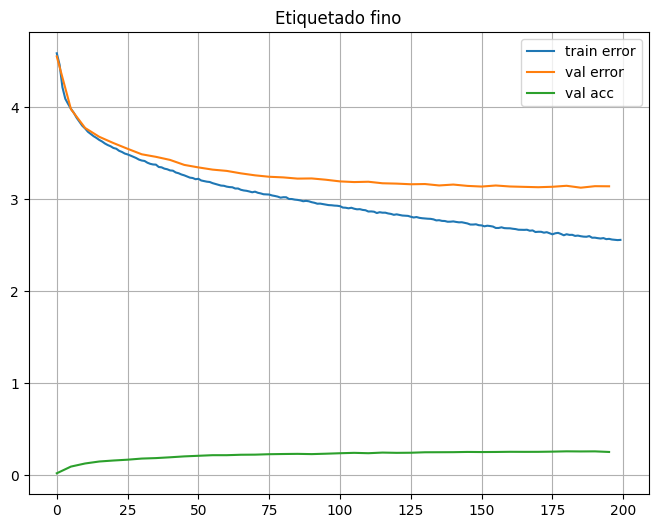

Precisión Modelo Fino (Experimento 1): 0.259
Matriz de confusión simple
torch.Size([10000])
torch.Size([10000])


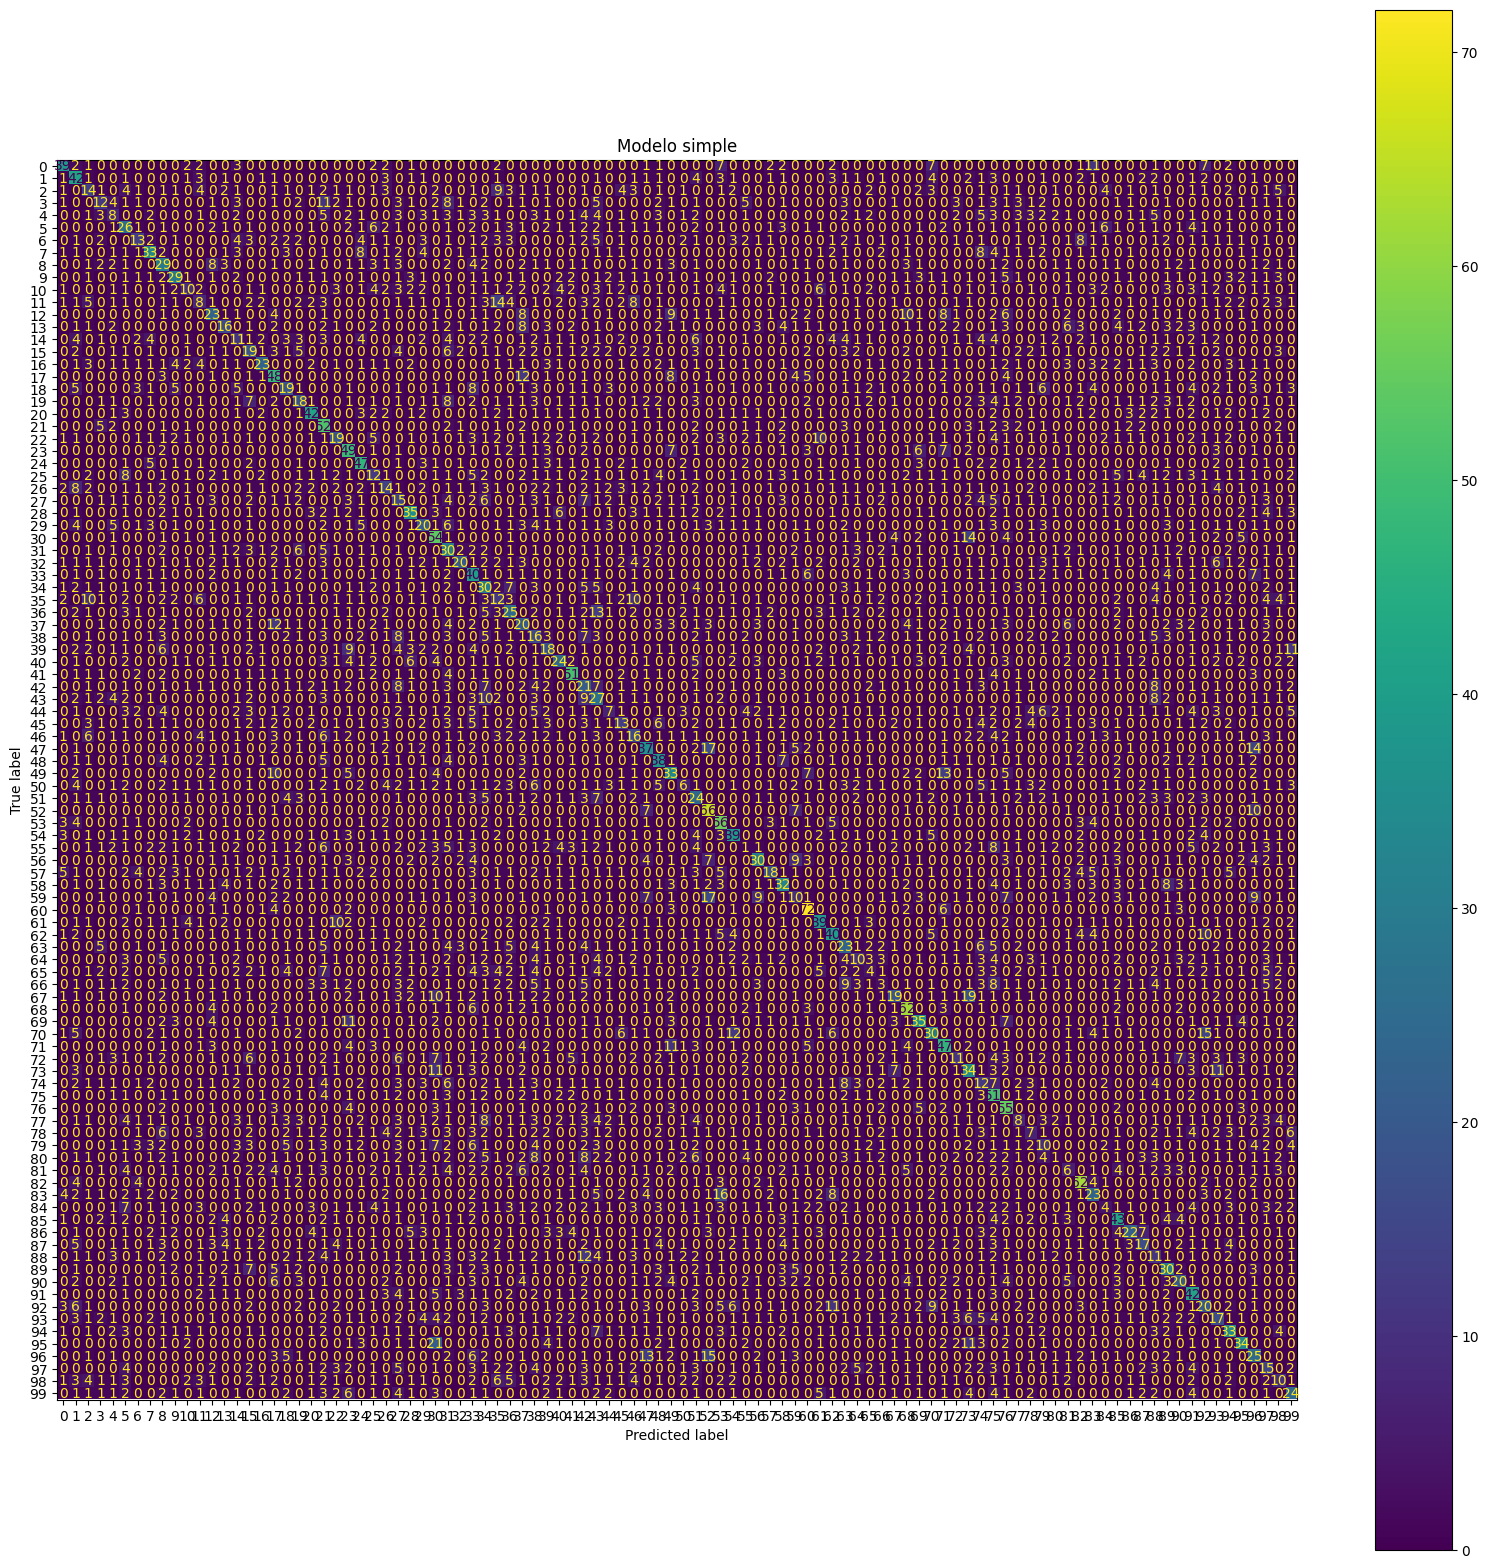

In [5]:
train_dataset_fino = torch.utils.data.TensorDataset(train_X.to(device_gpu), train_Y_fino.to(device_gpu))
val_dataset_fino = torch.utils.data.TensorDataset(val_X.to(device_gpu), val_Y_fino.to(device_gpu))
test_dataset_fino = torch.utils.data.TensorDataset(test_X.to(device_gpu), test_Y_fino.to(device_gpu))

train_dataloader_fino = DataLoader(train_dataset_fino, batch_size=batch_size, shuffle=True)
val_dataloader_fino = DataLoader(val_dataset_fino, batch_size=batch_size, shuffle=True)
test_dataloader_fino = DataLoader(test_dataset_fino, batch_size=batch_size, shuffle=False)

model_fino = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 256), # Dimensiones de entrada: 3 canales * 32 alto * 32 ancho
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 100) # 100 clases en CIFAR100
  ).to(device_gpu)

model_fino, train_loss, val_loss, val_acc = learning_loop_for_classification(
    train_dataloader_fino,
    val_dataloader_fino,
    model_fino,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, device = device_gpu)

#Graficos Perdida y Accuracy
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss)), train_loss, label="train error")
plt.plot(range(0, validation_freq*len(val_loss), validation_freq), val_loss, label="val error")
plt.plot(range(0, validation_freq*len(val_acc), validation_freq), val_acc, label="val acc")
plt.legend()
plt.grid(True)
plt.title("Etiquetado fino")
plt.show()


#Accuracy
correct = 0
total =  0
y_pred_list = []
y_test_list = []

with torch.no_grad():
    for x_test, y_test in test_dataloader_fino:
        x_test = x_test.to(device_gpu)
        y_test = y_test.to(device_gpu)

        # Obtener las predicciones del modelo
        y_test_pred = model_fino(x_test)

        # Obtener la clase predicha (la que tiene el valor más alto)
        preds = torch.argmax(y_test_pred, dim=-1)

        # Acumular el número de aciertos
        correct += (preds == y_test).sum().item()

        # Acumular el total de muestras
        total += y_test.size(0)

        #guardar datos para matriz
        y_pred_list.append(y_test_pred)
        y_test_list.append(y_test)

# Calcular la precisión final
acc_test_exp1 = correct / total
print(f"Precisión Modelo Fino (Experimento 1): {acc_test_exp1:}")

#Matriz Cofusion
print(f"Matriz de confusión simple")
y_test_final = torch.cat(y_test_list).cpu()
y_pred_final = torch.argmax(torch.cat(y_pred_list), dim=-1).cpu()
print(y_pred_final.shape)
print(y_test_final.shape)
cm = confusion_matrix(y_test_final, y_pred_final)
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot(ax=ax)
plt.title("Modelo simple")
plt.show()

**-EXPERIMENTO 2-**

-Aproximación con información del etiquetado grueso -

Primero calculo la Aproximación solo con etiquetado grueso

epoch:: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s, loss=1.5793538093566895]


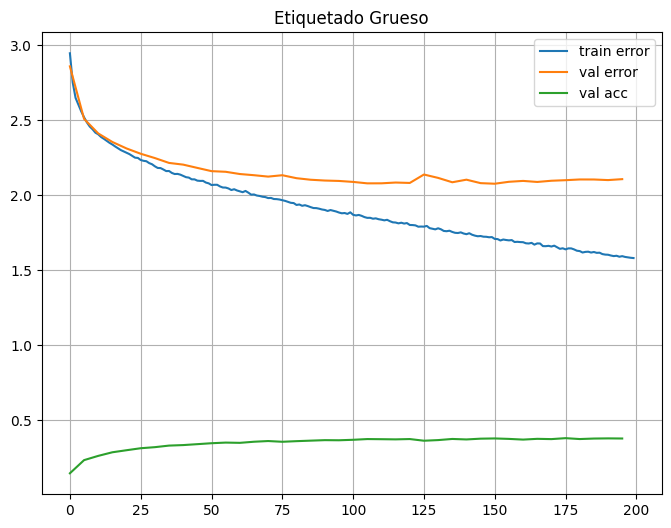

In [6]:
train_dataset_grueso = torch.utils.data.TensorDataset(train_X.to(device_gpu), train_Y_grueso.to(device_gpu))
val_dataset_grueso = torch.utils.data.TensorDataset(val_X.to(device_gpu), val_Y_grueso.to(device_gpu))
test_dataset_grueso = torch.utils.data.TensorDataset(test_X.to(device_gpu), test_Y_grueso.to(device_gpu))

train_dataloader_grueso = DataLoader(train_dataset_grueso, batch_size=batch_size, shuffle=True)
val_dataloader_grueso = DataLoader(val_dataset_grueso, batch_size=batch_size, shuffle=True)
test_dataloader_grueso = DataLoader(test_dataset_grueso, batch_size=batch_size, shuffle=False)

#Predecir las 20 superclases
model_grueso = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 32 * 32, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256,256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 20)  # 20 superclases
).to(device_gpu)



model_grueso, train_loss_g, val_loss_g, val_acc_g = learning_loop_for_classification(
    train_dataloader_grueso,
    val_dataloader_grueso,
    model_grueso,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq=validation_freq,
    device=device_gpu
)

#Graficos Perdida y Accuracy
plt.figure(figsize=(8,6))
plt.plot(range(len(train_loss_g)), train_loss_g, label="train error")
plt.plot(range(0, validation_freq*len(val_loss_g), validation_freq), val_loss_g, label="val error")
plt.plot(range(0, validation_freq*len(val_acc_g), validation_freq), val_acc_g, label="val acc")
plt.legend()
plt.grid(True)
plt.title("Etiquetado Grueso")
plt.show()


Ahora calculo la precisión compleja, con las probabilidades de las finas y las gruesas

Precisión Modelo Fino (Experimento 1): 0.259
Precisión Combinada (Experimento 2): 0.0255
Matriz de confusión copleja
torch.Size([10000])
torch.Size([10000])


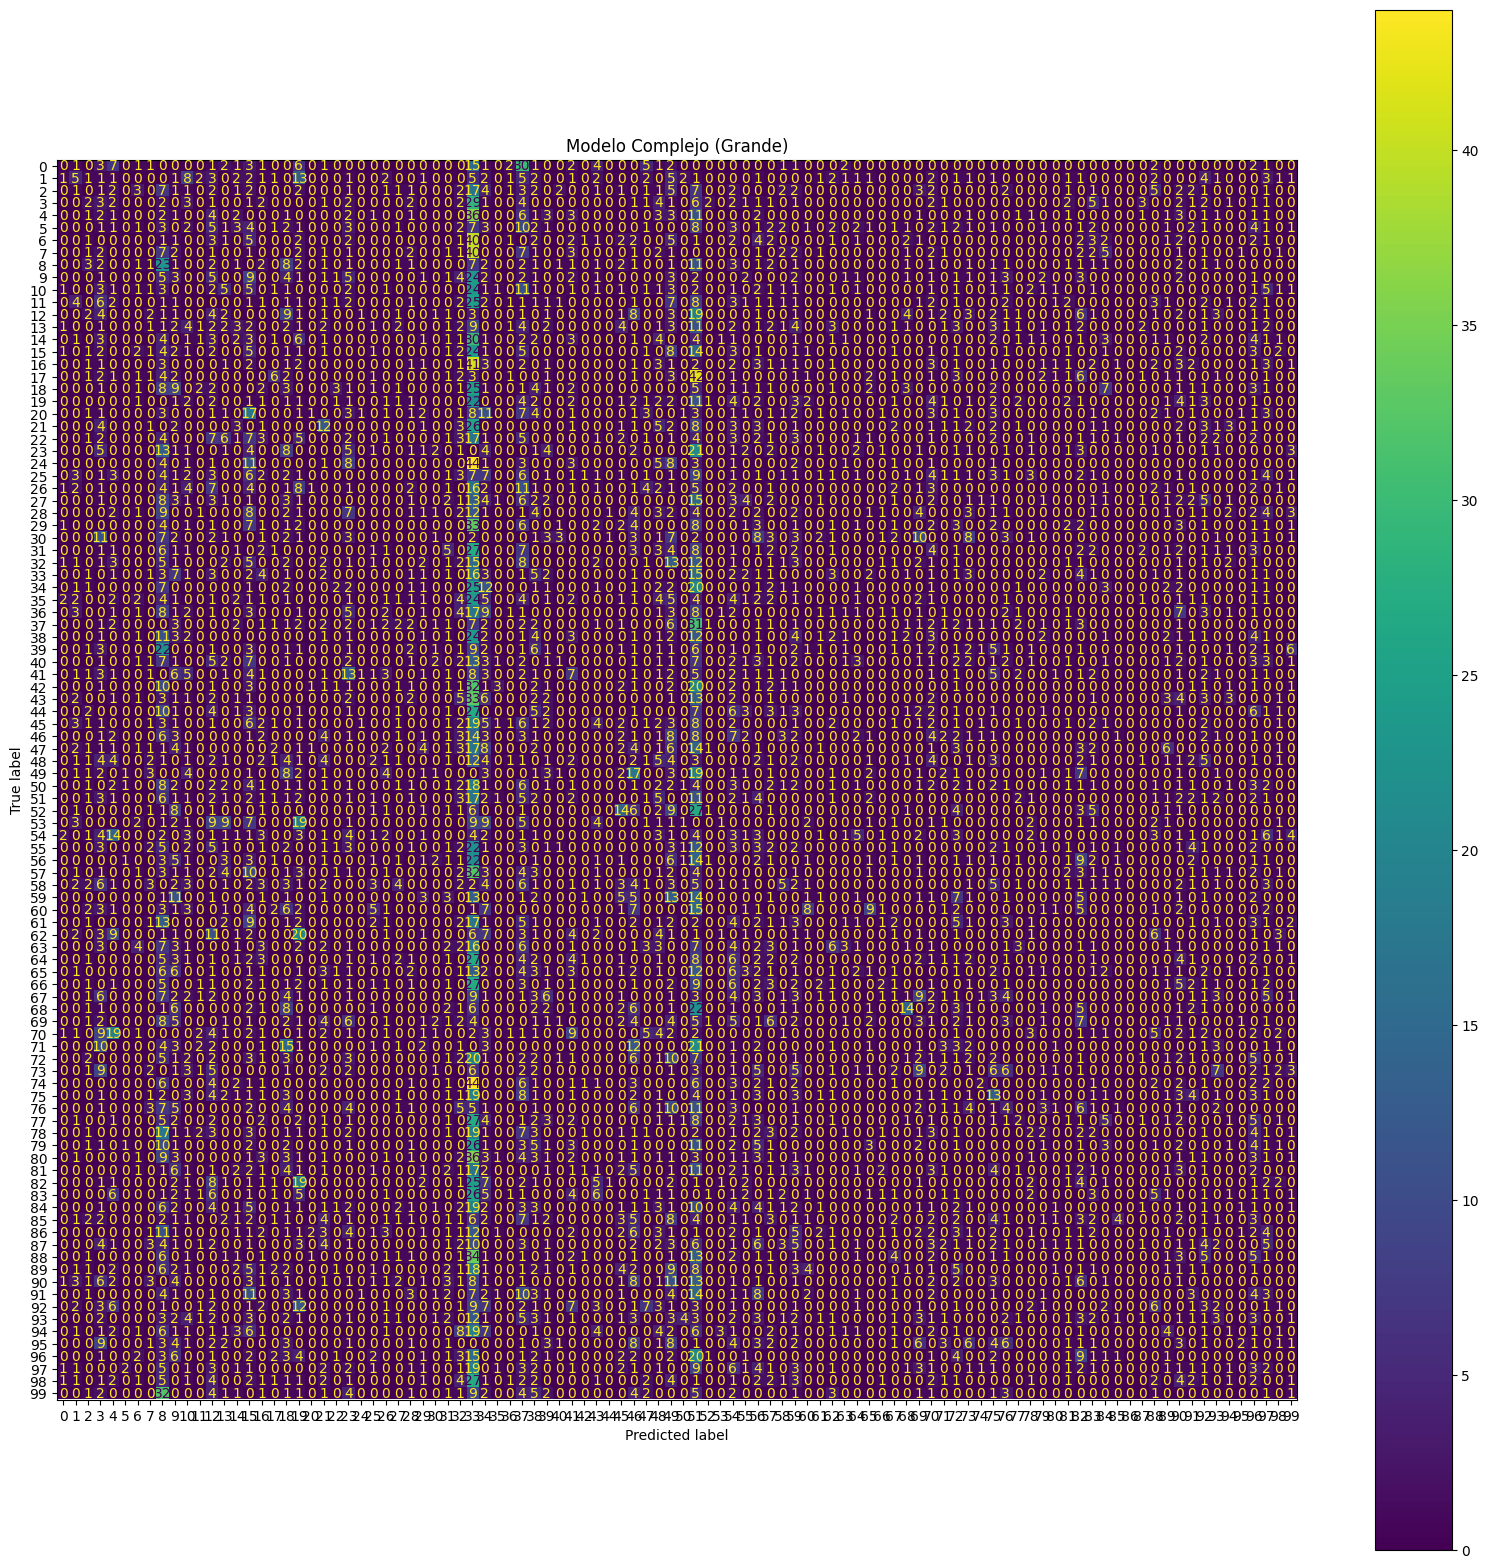

In [7]:
#Inicializo mapa vacio
fino_to_grueso_map = torch.zeros(100, dtype=torch.long, device=device_gpu)
train_Y_fino = train_Y_fino.to(device_gpu)
train_Y_grueso = train_Y_grueso.to(device_gpu)
#En la posición X del mapa (donde X es la etiqueta fina), guarda el valor Y (donde Y es la etiqueta gruesa)
fino_to_grueso_map[train_Y_fino] = train_Y_grueso

#Accuracy
aux = 1e-12 #Evitar division entre cero
correct = 0
total = 0
y_pred_c = []
y_test_c = []

with torch.no_grad():
    for x, y_fino in test_dataloader_fino:
        x = x.to(device_gpu)
        y_fino = y_fino.to(device_gpu)

        #Predicciones modelo fino
        y_fino_pred = model_fino(x)
        prob_fino = torch.softmax(y_fino_pred, dim=1)

        #Predicciones modelo grueso
        y_grueso_pred = model_grueso(x)
        prob_grueso = torch.softmax(y_grueso_pred, dim=1)

        #Expandimos las prob de las gruesas para que coincidan con las finas (prob_vehiculo, prob_mamifero), (moto, tren, coche, delfin)  --> (prob_vehiculo, prob_vehiculo, prob_vehiculo, prob_mamifero)
        prob_grueso_exp = prob_grueso[:, fino_to_grueso_map]

        #P(final) = P(fino) * P(grueso)
        prob_final = prob_fino / (prob_grueso_exp + aux)

        # Obtener la clase predicha (la que tiene el valor más alto)
        final_pred = torch.argmax(prob_final, dim=1)

        #acumular aciertos
        correct += (final_pred == y_fino).sum().item()
        total += y_fino.size(0)

        #guardar datos para matriz
        y_pred_c.append(final_pred)
        y_test_c.append(y_fino)


acc_combinado = correct / total

print(f"Precisión Modelo Fino (Experimento 1): {acc_test_exp1:}")
print(f"Precisión Combinada (Experimento 2): {acc_combinado:}")

#Matriz confusion compleja
print(f"Matriz de confusión copleja")
y_test = torch.cat(y_test_c).cpu()
y_pred = torch.cat(y_pred_c).cpu()

print(y_pred.shape)
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot(ax=ax)
plt.title("Modelo Complejo (Grande)")
plt.show()

**CONCLUSIÓN**

Se comprueba que la incorporación del etiquetado grueso mediante la fórmula de probabilidad condicionada no mejora, sino que degrada el rendimiento.

Esto se debe a la inestabilidad numérica generada al dividir por probabilidades pequeñas cuando el clasificador grueso no tiene suficiente confianza.

El error del modelo grueso, al estar en el denominador, amplifica el ruido del modelo fino en lugar de filtrarlo.

**CORRECCION DE LA FORMULA**

Ahora voy a aplicar la formula correcta:
$$P(A \cap B) = P(A|B)*P(B)$$




Accuracy simple: 0.259
Accuracy complejo: 0.2332


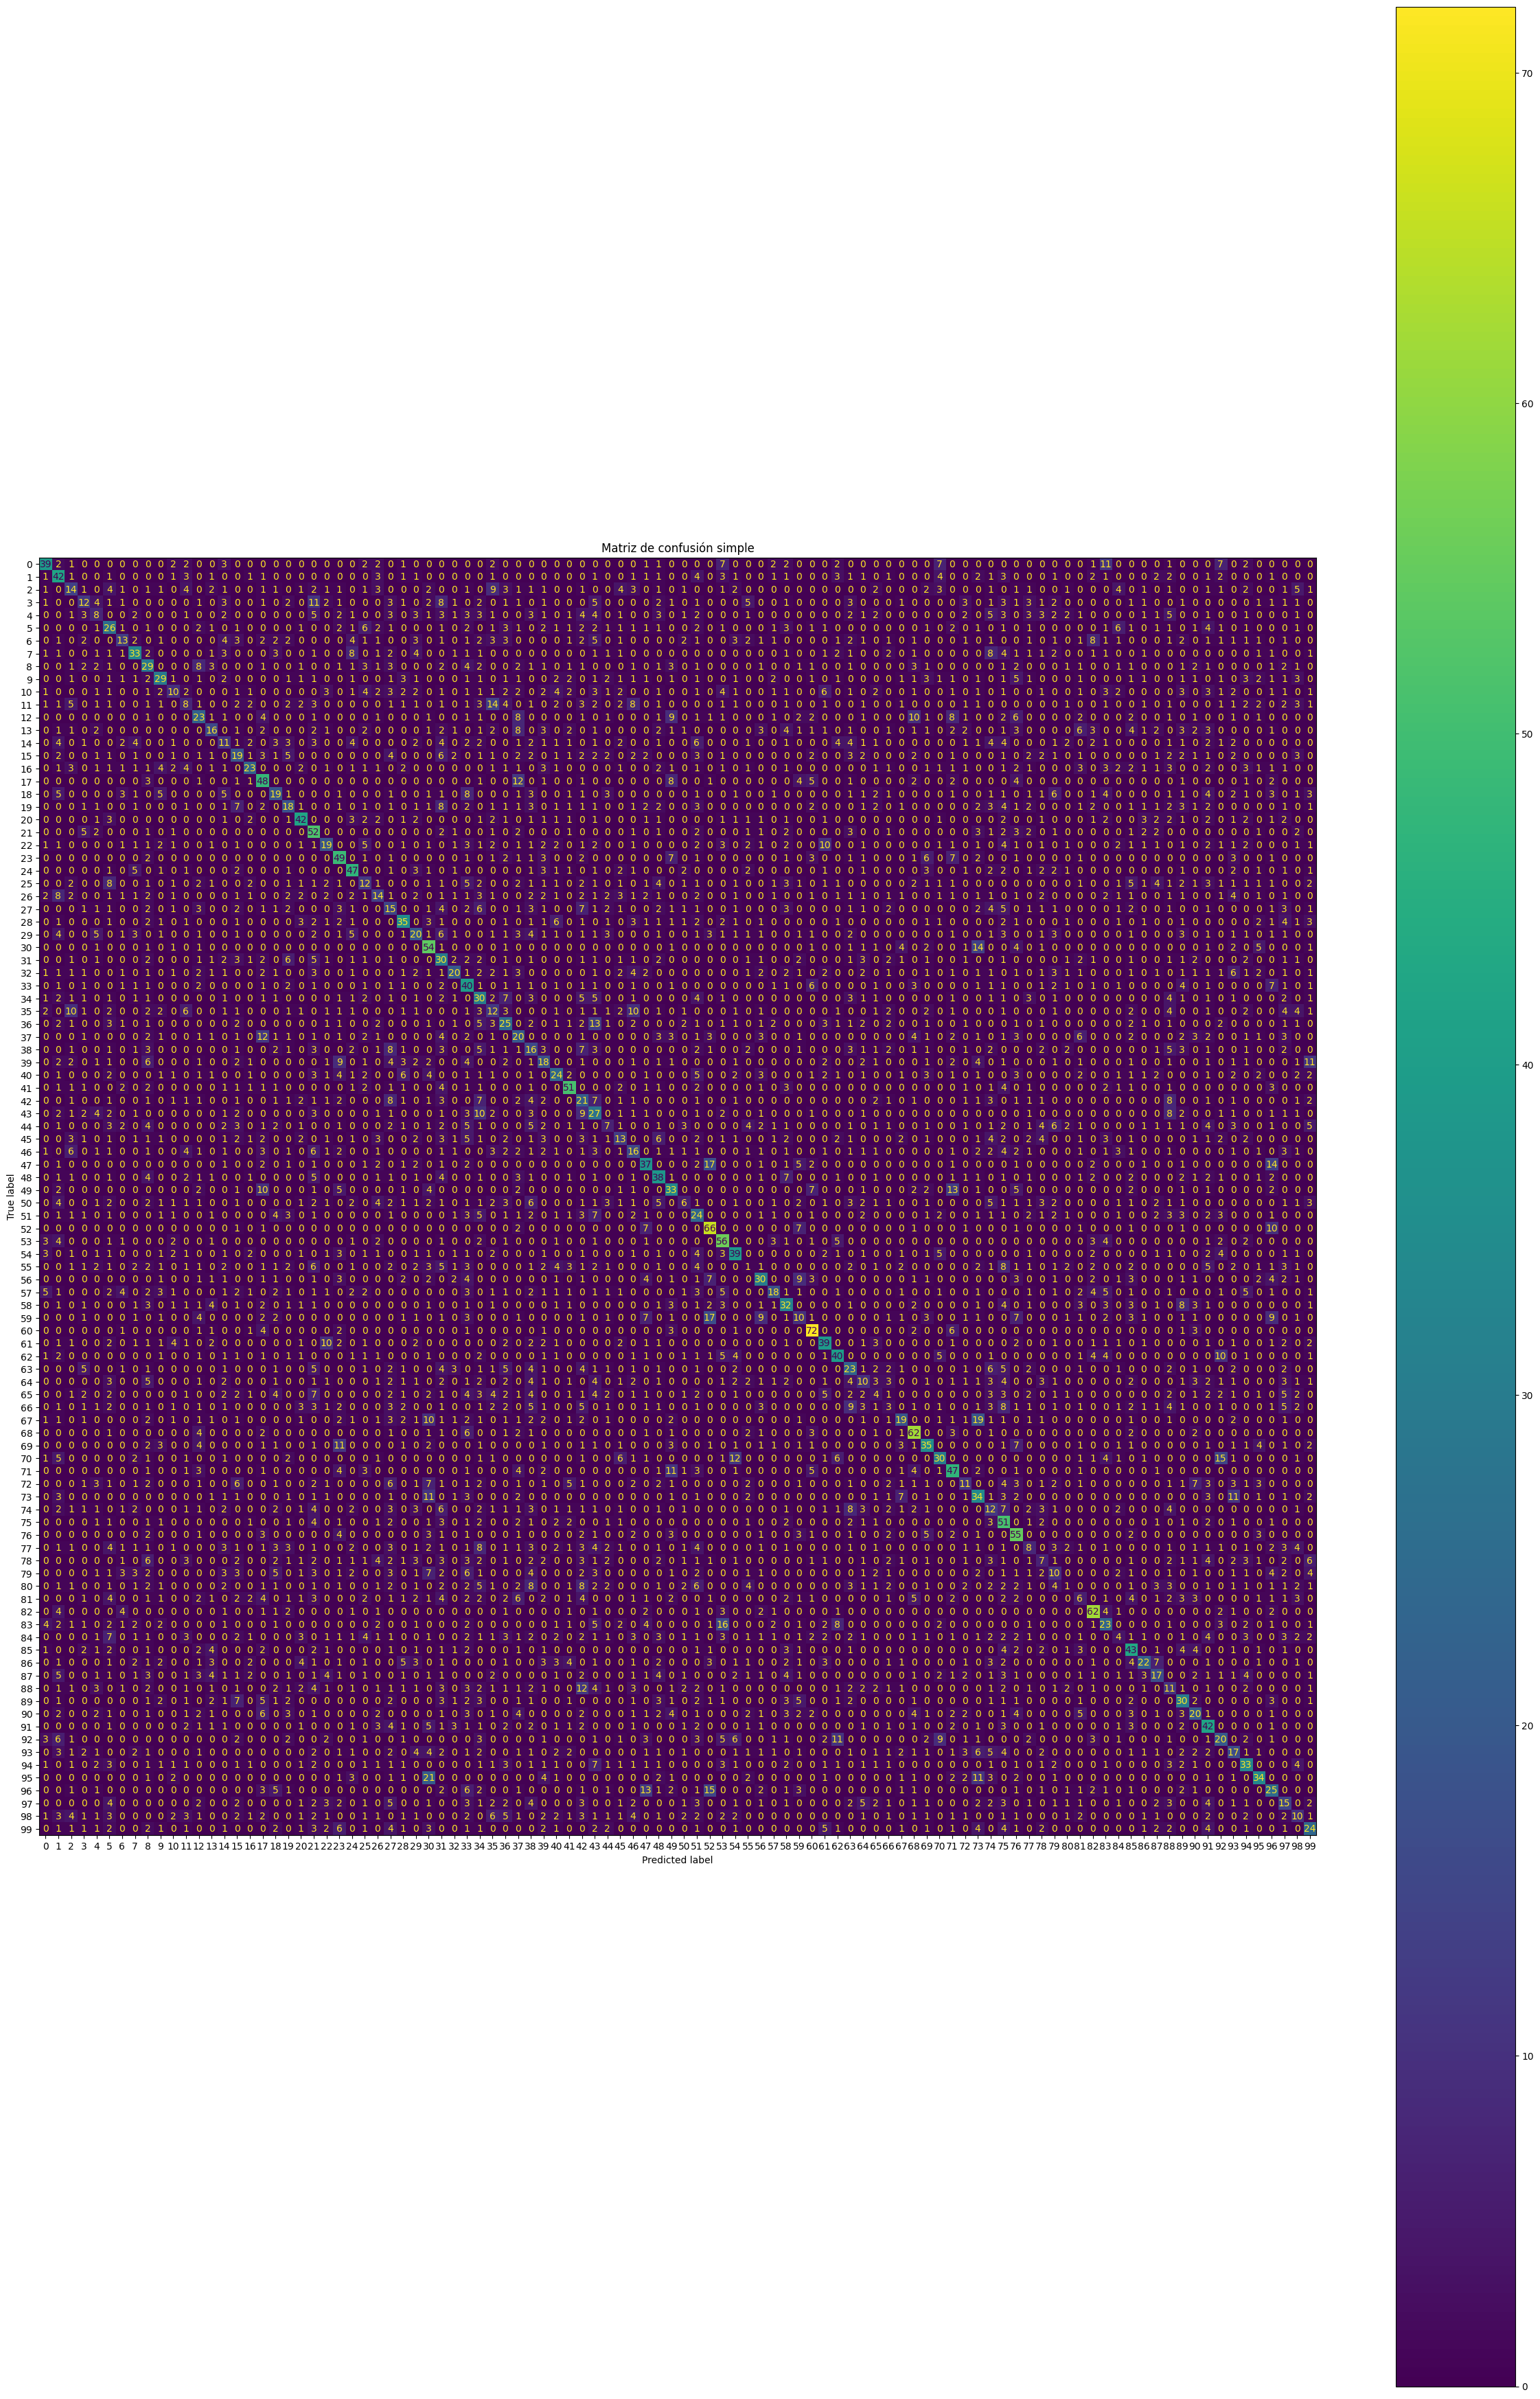

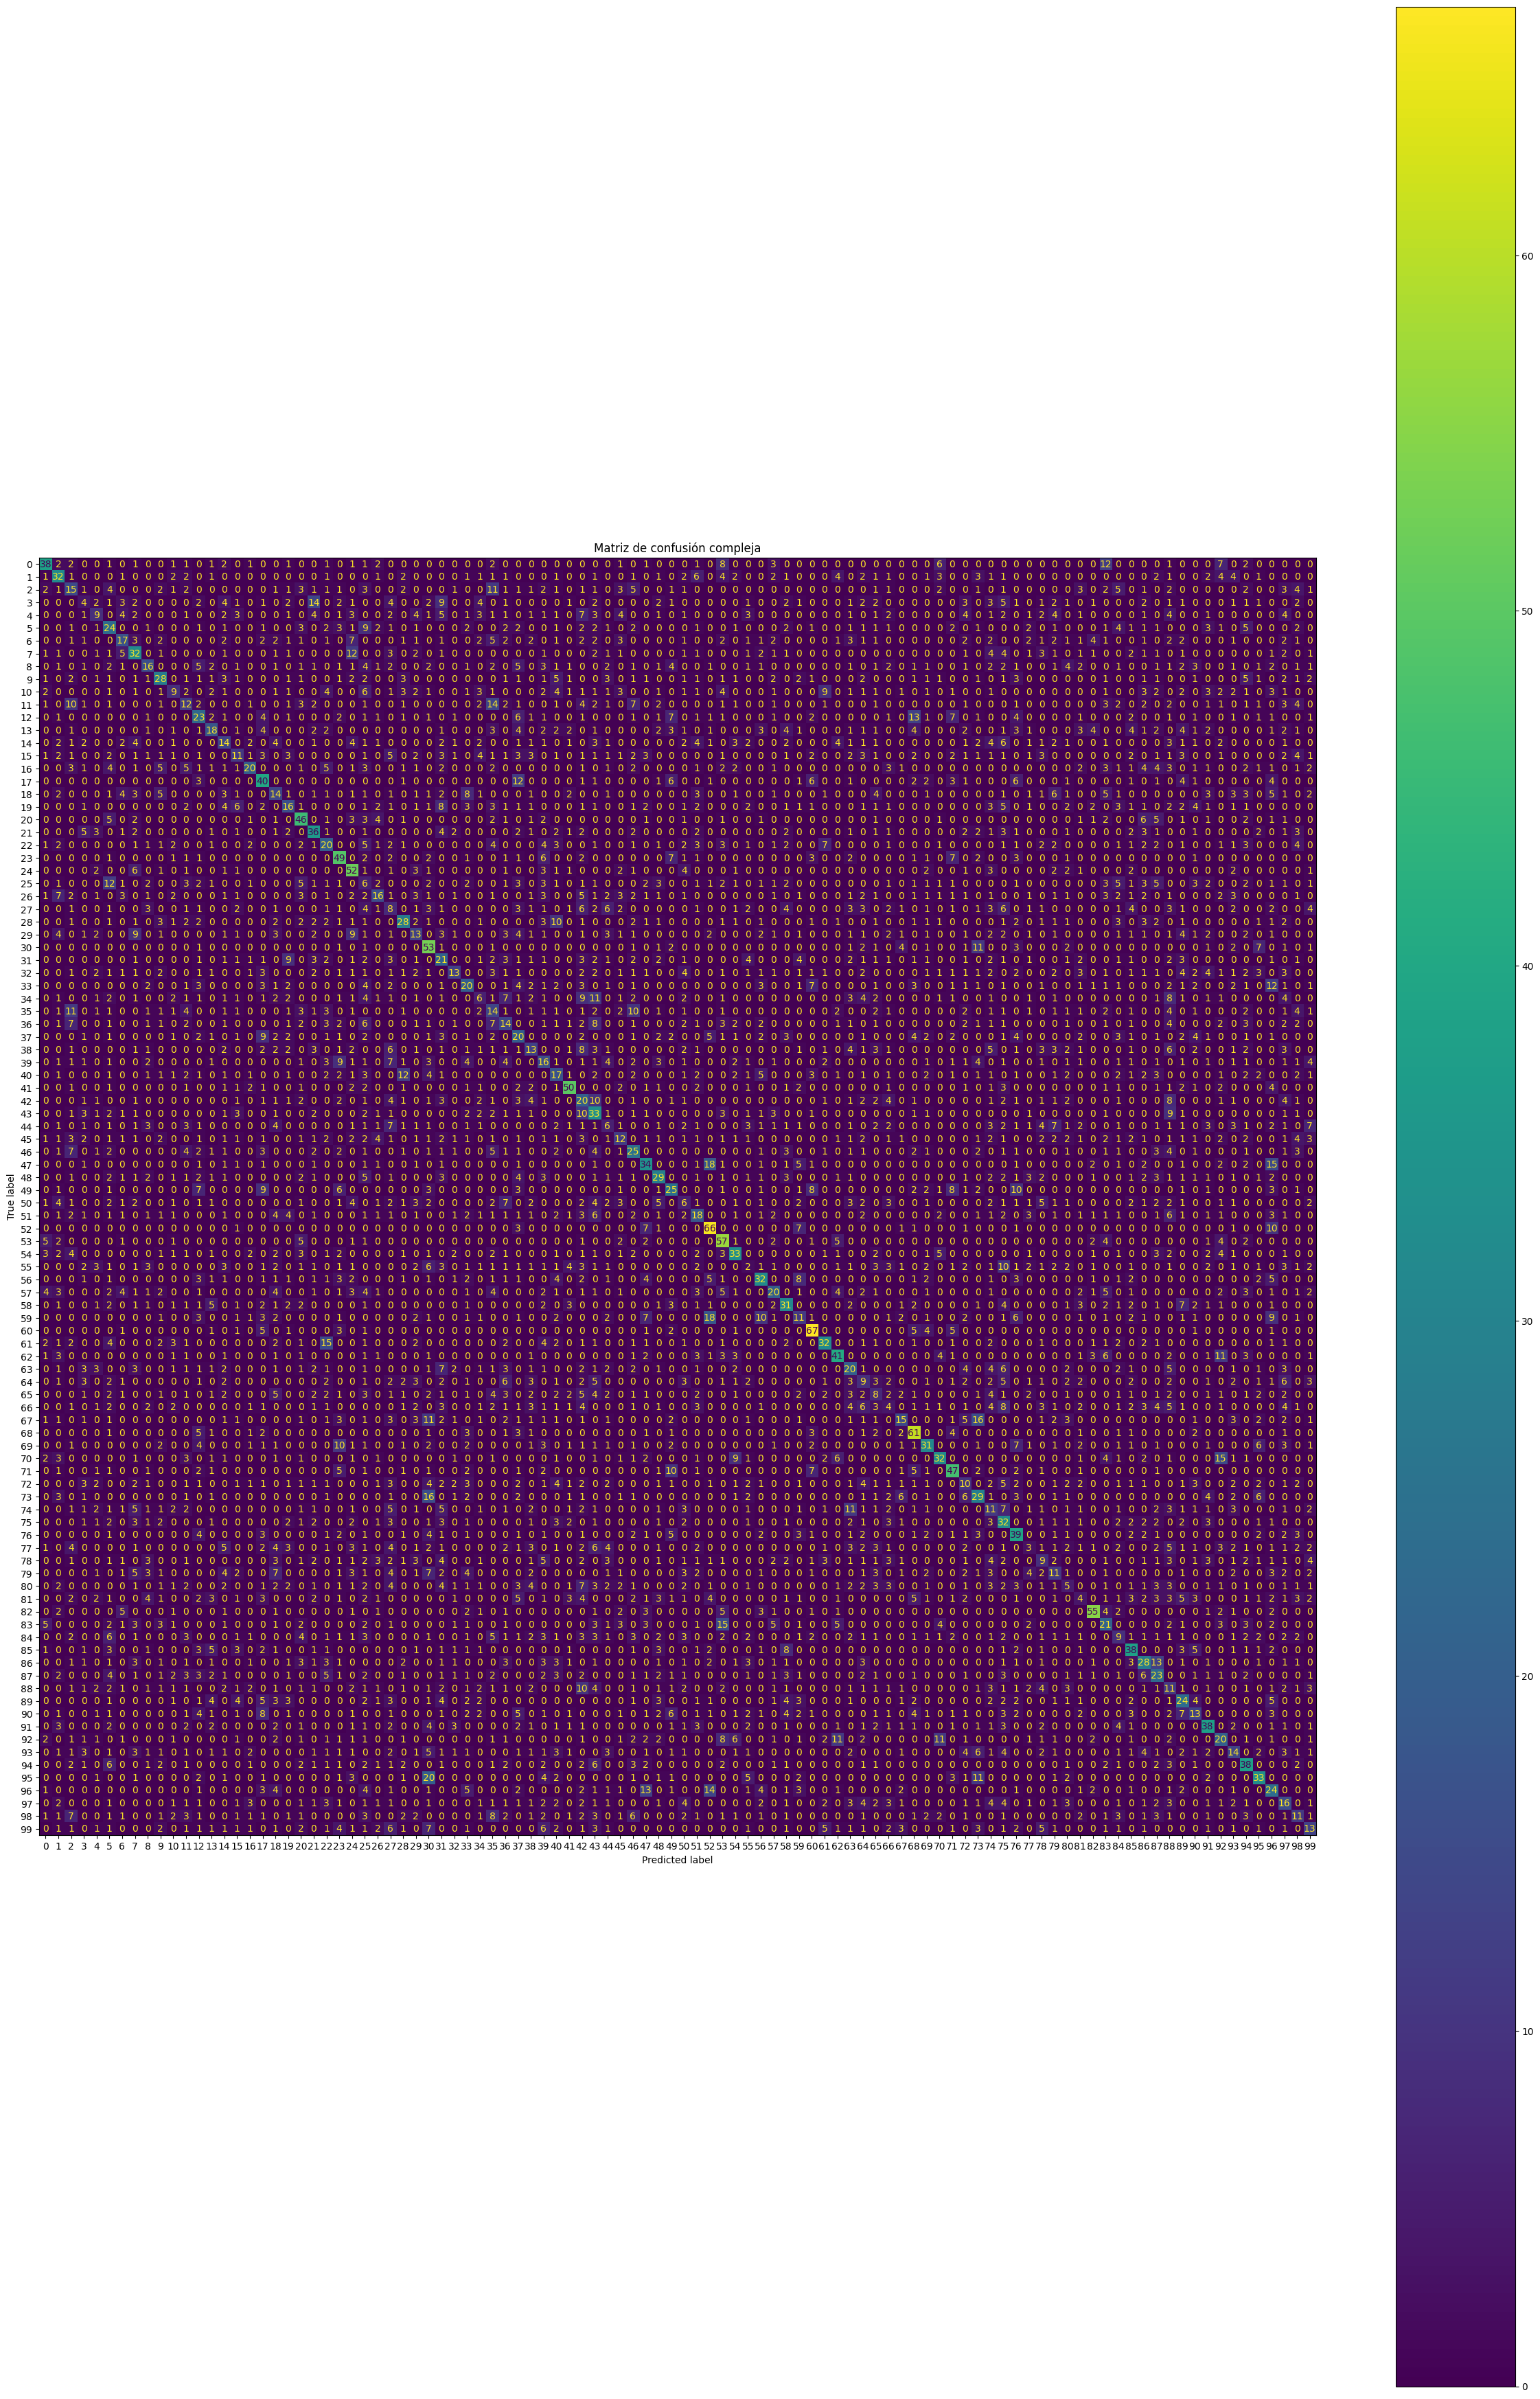

In [9]:
#test
correct_simple= 0
correct_complejo= 0
total = 0
y_pred_simple_list = []
y_pred_complex_list = []
y_test_fine_list=[]

#Creamos una matriz binaria donde situamos un 1 en aquellas clases que pertenecen a la superclase determinada por la fila correspondiente, y 0 a las demás
map = torch.zeros(20, 100, device=device_gpu)
map[train_Y_grueso, train_Y_fino] = 1.0


with torch.no_grad():
  for x_test, y_test_true_fino in test_dataloader_fino:
    x_test = x_test.to(device_gpu)
    y_fine = y_test_true_fino.to(device_gpu)

    #Predicciones obtenidas
    pred_fino = model_fino(x_test)
    pred_grueso = model_grueso(x_test)

    #Aproximación sencilla:
    #cogemos las clases con prob más alta
    preds_simple=torch.argmax(pred_fino, dim=-1)
    correct_simple += torch.sum(preds_simple==y_test_true_fino).item()

    #Aproximación compleja:
    #obtenemos las probabilidades
    prob_fino = torch.softmax(pred_fino, dim=1)
    prob_grueso = torch.softmax(pred_grueso, dim=1)

    #Obtengo la prediccion de la superclase mas probable
    pred_grueso = torch.argmax(pred_grueso, dim=-1)

    #Saco la fila de la superclase seleccionada como predicción
    batch_mask = map[pred_grueso]
    #anulamos las probabilidades de las clases finas que no pertenezcan a la superclase predicha
    prob_fine_masked = prob_fino*batch_mask
    #Normalizo las probabilidades
    prob_sum_coarse = prob_fine_masked.sum(dim=1, keepdim = True)

    #Probabilidad de la clase fina dada la superclase predicha P(A|B)
    prob_A_dado_B = prob_fine_masked/(prob_sum_coarse + aux)
    #Probabilidad de la superclase predicha P(B)
    prob_B = prob_grueso[torch.arange(prob_grueso.size(0)), pred_grueso].unsqueeze(1)

    #P(final) = P(A|B) * P(B)
    prob_complejo = prob_A_dado_B*prob_B

    #Obtenemos la predicción final
    preds_complejo = torch.argmax(prob_complejo, dim=-1)
    correct_complejo += torch.sum(preds_complejo==y_test_true_fino).item()

    #acumulo resultados
    total += y_test_true_fino.numel()
    y_pred_simple_list.append(preds_simple.cpu())
    y_pred_complex_list.append(preds_complejo.cpu())
    y_test_fine_list.append(y_test_true_fino.cpu())

#accuracy de cada experimento
acc_simple = correct_simple/total
acc_complejo = correct_complejo/total
print(f"Accuracy simple: {acc_simple}")
print(f"Accuracy complejo: {acc_complejo}")

#Calculamos la matriz de confusión de cada experimento
y_test_all = torch.cat(y_test_fine_list)
y_pred_simple_all = torch.cat(y_pred_simple_list)
y_pred_complex_all = torch.cat(y_pred_complex_list)

cm_simple = confusion_matrix(y_test_all, y_pred_simple_all)
plt.figure(figsize=(30,45))
ax_simple=plt.gca()
disp_simple = ConfusionMatrixDisplay(confusion_matrix=cm_simple)
disp_simple.plot(ax=ax_simple)
plt.title("Matriz de confusión simple")
plt.show()

cm_complex = confusion_matrix(y_test_all, y_pred_complex_all)
plt.figure(figsize=(30,45))
ax_complex=plt.gca()
disp_complex = ConfusionMatrixDisplay(confusion_matrix=cm_complex)
disp_complex.plot(ax=ax_complex)
plt.title("Matriz de confusión compleja")
plt.show()
